In [7]:
import sys
sys.path.append('./../')
from src import proyecto_1
from src.pipelines import modeling
from src.pipelines import model_evaluation
from src.utils import utils
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
import sklearn.metrics as metrics
import random
from datetime import datetime

./../src/pipelines/feature_engineering.py:25: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)
/Users/yedam/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yedam/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


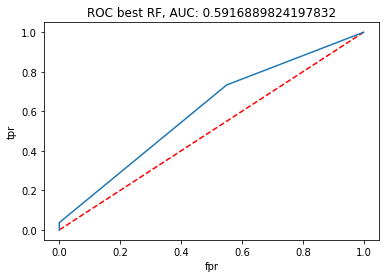

In [2]:
random.seed(1234)
proyecto_1.main()

## Curva ROC

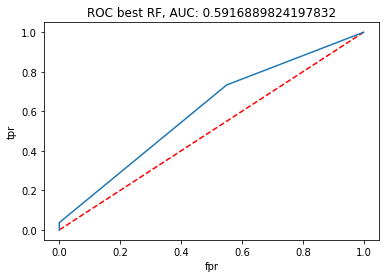

In [14]:
models = utils.load_df('output/model_loop.pkl')
#Carga de datos de train y test
c5_train = utils.load_df('output/fe_df.pkl')
c5_test = utils.load_df('output/test.pkl')
#Preparacion de datos test
c5_test_ = c5_test.copy()
c5_train_ = c5_train.copy()
c5_train_ = c5_train_.drop('label',axis=1)
names=np.array(c5_test_.dia_semana.unique())
names=np.append(names,np.array(c5_test_.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_test_.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_test_.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))   
#Definicion de transformers
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
        ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
        ('mes', SimpleImputer(strategy="mean"), ['mes']),
        ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
        ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
col_trans.fit(c5_test_)
df_input_vars = col_trans.transform(c5_test_)
X = df_input_vars
y = c5_test.label.values.reshape(df_input_vars.shape[0],)
    
X_test = pd.DataFrame.sparse.from_spmatrix(X)
X_test.columns = names
X_test
selection_test = list(c5_train_.columns)
selection_test
X_test_ = X_test[selection_test]
prediction = (models[1].best_estimator_.predict_proba(X_test_)[:,1] >=0.210635).astype(bool)
proba = models[1].best_estimator_.predict_proba(X_test_)

fpr, tpr, thresholds = roc_curve(y, proba[:,1], pos_label=1)
    
plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y, prediction)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Precision&Recall 

,k,precision,recall
0,0.01,0.255165,0.733168
1,0.02,0.255165,0.733168
2,0.03,0.255165,0.733168
3,0.04,0.255165,0.733168
4,0.05,0.255165,0.733168
...,...,...,...
94,0.95,0.204388,1.000000
95,0.96,0.204388,1.000000
96,0.97,0.204388,1.000000
97,0.98,0.204388,1.000000


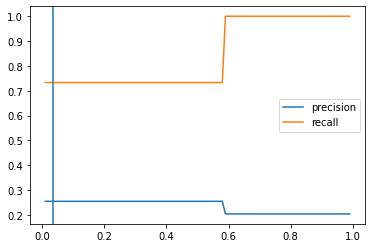

In [8]:
precision, recall, thresholds_2 = precision_recall_curve(y, proba[:,1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)

def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.recall_score(y_true, y_pred)

def get_top_k(y,y_scores,k):
    array=np.stack((y, y_scores), axis=-1)
    ordena_k = array[np.argsort(array[:, 1])[::-1]]
    k_porc = int(len(y_scores)*k)
    top = ordena_k[:k_porc]
    return top[:,[0]],top[:,[1]]

def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.01, 1, 0.01))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
         ## get_top_k es una función que ordena los scores de
         ## mayor a menor y toma los k% primeros
         #top_k_y,top_k_proba = get_top_k(y_true,y_scores, k)
         #d['precision'] = precision_at_k(top_k_y,top_k_proba,k)
         #d['recall'] = recall_at_k(top_k_y,top_k_proba,k)
        d['precision'] = precision_at_k(y_true, y_scores,k)
        d['recall'] = recall_at_k(y_true, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    #ax1.plot([k,k],[1,0], 'k--', c='red')
    
    plt.legend()
    
    c5 = utils.load_df('output/ingest_df.pkl')
    min_fecha = '01/01/2014'
    max_fecha = '12/10/2020'
    min_fecha = datetime.strptime(min_fecha, '%d/%m/%Y')
    max_fecha = datetime.strptime(max_fecha, '%d/%m/%Y')
    dias = max_fecha-min_fecha
    dias
    ambulancias = 20
    dias=2476
    acc = c5['dia_semana'].count()
    acc_x_dia = acc/dias
    k = ambulancias / acc_x_dia
    k
    
    plt.axvline(x=k)

    #if save_target is not None:
    #    plt.savefig(save_target)

    return pr_k

pr_k_curve(y, proba[:,1],0)

## Metricas Offline

In [9]:
metricas_offline = utils.load_df('./output/metricas_offline.pkl')
metricas_offline

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.159716,0.204388,1.000000,0.339406,1.000000,1.000000,0.000000,0.000000
1,0.210635,0.255165,0.733168,0.378575,0.733168,0.549790,0.450210,0.266832
2,0.232394,0.945011,0.037707,0.072520,0.037707,0.000564,0.999436,0.962293
3,0.507171,1.000000,0.037070,0.071490,0.037070,0.000000,1.000000,0.962930


In [13]:
#Plot matriz de confusion
(confusion_matrix(y, prediction))

array([[ 99043, 120950],
       [ 15080,  41435]])

In [12]:
#Plot accuracy
accuracy_score(y, prediction)

0.5080431669246459

## Aequitas

In [15]:
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [16]:
c5_aeq = pd.DataFrame({'score':prediction, 'label_value': y, 'delegacion': c5_test['delegacion_inicio']})
c5_aeq['delegacion'] = c5_aeq['delegacion'].astype(str)

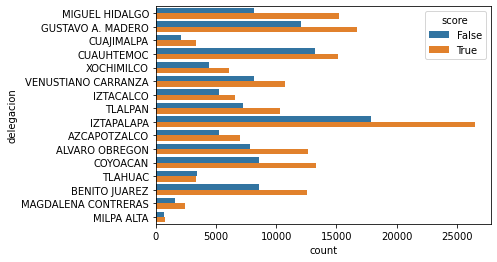

In [17]:
by_delegacion = sns.countplot(y="delegacion", hue="score", data=c5_aeq)

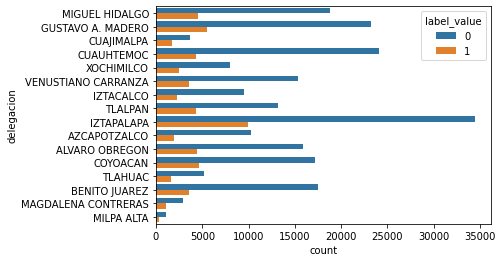

In [18]:
by_delegacion = sns.countplot(y="delegacion", hue="label_value", data=c5_aeq)

### Group

In [19]:
g = Group()
xtab, attrbs = g.get_crosstabs(c5_aeq)

model_id, score_thresholds 0 {'rank_abs': [162385]}


In [20]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,162385,delegacion,ALVARO OBREGON,0.731724,0.413735,0.154143,0.740321,0.586265,...,0.618176,9331,1200,6585,3273,4473,15916,20389,276508,0.219383
1,0,binary 0/1,162385,delegacion,AZCAPOTZALCO,0.697722,0.450950,0.114237,0.803536,0.549050,...,0.573039,5636,597,4629,1378,1975,10265,12240,276508,0.161356
2,0,binary 0/1,162385,delegacion,BENITO JUAREZ,0.749165,0.437464,0.105417,0.785115,0.562536,...,0.594352,9832,901,7646,2691,3592,17478,21070,276508,0.170479
3,0,binary 0/1,162385,delegacion,COYOACAN,0.763636,0.433180,0.129331,0.731660,0.566820,...,0.608934,9734,1105,7439,3570,4675,17173,21848,276508,0.213978
4,0,binary 0/1,162385,delegacion,CUAJIMALPA,0.680851,0.412781,0.269417,0.643910,0.587219,...,0.617456,2141,555,1505,1184,1739,3646,5385,276508,0.322934
5,0,binary 0/1,162385,delegacion,CUAUHTEMOC,0.693597,0.495613,0.099441,0.802820,0.504387,...,0.533060,12129,1316,11918,2979,4295,24047,28342,276508,0.151542
6,0,binary 0/1,162385,delegacion,GUSTAVO A. MADERO,0.748014,0.459148,0.115735,0.751975,0.540852,...,0.580744,12564,1396,10666,4144,5540,23230,28770,276508,0.192562
7,0,binary 0/1,162385,delegacion,IZTACALCO,0.706394,0.481349,0.128425,0.752439,0.518651,...,0.555179,4936,675,4581,1624,2299,9517,11816,276508,0.194567
8,0,binary 0/1,162385,delegacion,IZTAPALAPA,0.738759,0.443721,0.145303,0.722816,0.556279,...,0.597165,19151,2597,15276,7344,9941,34427,44368,276508,0.224058
9,0,binary 0/1,162385,delegacion,MAGDALENA CONTRERAS,0.745573,0.446186,0.175676,0.665272,0.553814,...,0.605984,1590,273,1281,800,1073,2871,3944,276508,0.272059


In [21]:
absolute_metrics = g.list_absolute_metrics(xtab)

Frecuencias

In [22]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,162385,delegacion,ALVARO OBREGON,12604,7785,9331,1200,6585,3273,4473,15916,20389,276508
1,0,binary 0/1,162385,delegacion,AZCAPOTZALCO,7014,5226,5636,597,4629,1378,1975,10265,12240,276508
2,0,binary 0/1,162385,delegacion,BENITO JUAREZ,12523,8547,9832,901,7646,2691,3592,17478,21070,276508
3,0,binary 0/1,162385,delegacion,COYOACAN,13304,8544,9734,1105,7439,3570,4675,17173,21848,276508
4,0,binary 0/1,162385,delegacion,CUAJIMALPA,3325,2060,2141,555,1505,1184,1739,3646,5385,276508
5,0,binary 0/1,162385,delegacion,CUAUHTEMOC,15108,13234,12129,1316,11918,2979,4295,24047,28342,276508
6,0,binary 0/1,162385,delegacion,GUSTAVO A. MADERO,16708,12062,12564,1396,10666,4144,5540,23230,28770,276508
7,0,binary 0/1,162385,delegacion,IZTACALCO,6560,5256,4936,675,4581,1624,2299,9517,11816,276508
8,0,binary 0/1,162385,delegacion,IZTAPALAPA,26495,17873,19151,2597,15276,7344,9941,34427,44368,276508
9,0,binary 0/1,162385,delegacion,MAGDALENA CONTRERAS,2390,1554,1590,273,1281,800,1073,2871,3944,276508


Absolutos

In [23]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(4)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,ALVARO OBREGON,0.7317,0.4137,0.1541,0.7403,0.5863,0.2683,0.8459,0.2597,0.0776,0.6182,0.2194
1,delegacion,AZCAPOTZALCO,0.6977,0.4509,0.1142,0.8035,0.5491,0.3023,0.8858,0.1965,0.0432,0.5730,0.1614
2,delegacion,BENITO JUAREZ,0.7492,0.4375,0.1054,0.7851,0.5625,0.2508,0.8946,0.2149,0.0771,0.5944,0.1705
3,delegacion,COYOACAN,0.7636,0.4332,0.1293,0.7317,0.5668,0.2364,0.8707,0.2683,0.0819,0.6089,0.2140
4,delegacion,CUAJIMALPA,0.6809,0.4128,0.2694,0.6439,0.5872,0.3191,0.7306,0.3561,0.0205,0.6175,0.3229
5,delegacion,CUAUHTEMOC,0.6936,0.4956,0.0994,0.8028,0.5044,0.3064,0.9006,0.1972,0.0930,0.5331,0.1515
6,delegacion,GUSTAVO A. MADERO,0.7480,0.4591,0.1157,0.7520,0.5409,0.2520,0.8843,0.2480,0.1029,0.5807,0.1926
7,delegacion,IZTACALCO,0.7064,0.4813,0.1284,0.7524,0.5187,0.2936,0.8716,0.2476,0.0404,0.5552,0.1946
8,delegacion,IZTAPALAPA,0.7388,0.4437,0.1453,0.7228,0.5563,0.2612,0.8547,0.2772,0.1632,0.5972,0.2241
9,delegacion,MAGDALENA CONTRERAS,0.7456,0.4462,0.1757,0.6653,0.5538,0.2544,0.8243,0.3347,0.0147,0.6060,0.2721


In [24]:
xtab.fpr.median().round(5)

0.54495

Vamos a tomar la Delegación Gustavo A. Madero como nuestro grupo de referencia pues la mediana de los fpr es la que más se acerca y así podremos ver si hay algún sesgo entre las demás delegaciones.

Vamos a tomar las siguientes métricas:

PPR Predicted Positive Rate: Nos interesa para saber cuántas predijimos como falsas y realmente lo eran.

FPR False Positive Rate: Nos interesa para saber las que nos dice son falsas cuando realmente son verdaderas nos interesa para mandar la ambulancia a quién la necesita.

FDR False Discovery Rate: Nos interesa para saber fracción de personas que realmente necesitan la ambulancia y fueron predichos como falsos.

Visualización de sesgo en los grupos

In [25]:
aeq = Plot()

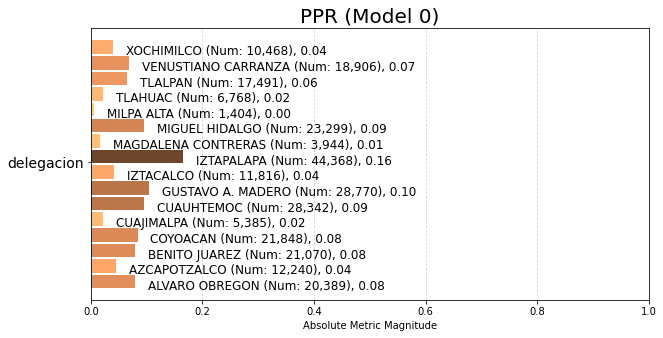

In [26]:
fdr = aeq.plot_group_metric(xtab, 'ppr')

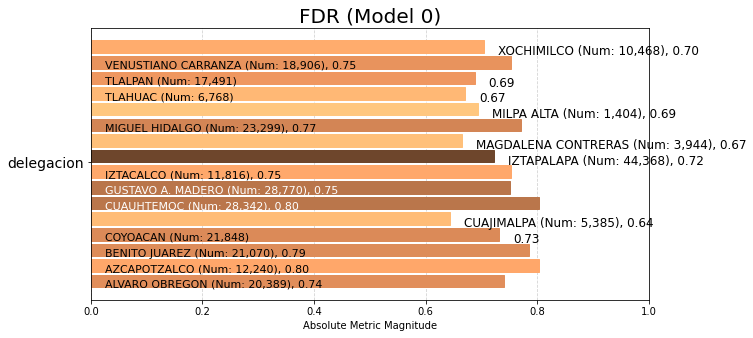

In [27]:
fdr = aeq.plot_group_metric(xtab, 'fdr')

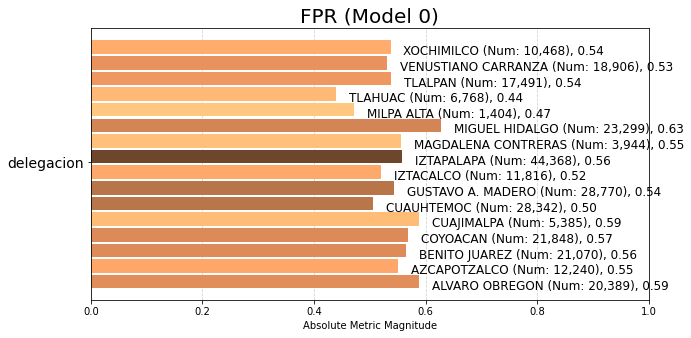

In [28]:
fdr = aeq.plot_group_metric(xtab, 'fpr')

### Bias

In [29]:
bias = Bias()

In [30]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=c5_aeq, 
                                        ref_groups_dict={'delegacion':'GUSTAVO A. MADERO'}, 
                                        alpha=0.05)

get_disparity_predefined_group()


In [31]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,0.75,1.06,1.05,0.98,1.33,1.08,1.06,0.98,0.90,0.96
1,delegacion,AZCAPOTZALCO,0.42,0.99,0.79,1.07,0.99,1.02,1.20,0.93,0.98,1.00
2,delegacion,BENITO JUAREZ,0.75,1.02,0.87,1.04,0.91,1.04,1.00,1.00,0.95,1.01
3,delegacion,COYOACAN,0.80,1.05,1.08,0.97,1.12,1.05,0.94,1.02,0.94,0.98
4,delegacion,CUAJIMALPA,0.20,1.06,1.44,0.86,2.33,1.09,1.27,0.91,0.90,0.83
5,delegacion,CUAUHTEMOC,0.90,0.92,0.80,1.07,0.86,0.93,1.22,0.93,1.08,1.02
6,delegacion,GUSTAVO A. MADERO,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,delegacion,IZTACALCO,0.39,0.96,1.00,1.00,1.11,0.96,1.17,0.94,1.05,0.99
8,delegacion,IZTAPALAPA,1.59,1.03,1.12,0.96,1.26,1.03,1.04,0.99,0.97,0.97
9,delegacion,MAGDALENA CONTRERAS,0.14,1.04,1.35,0.88,1.52,1.02,1.01,1.00,0.97,0.93


In [32]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=c5_aeq)

get_disparity_major_group()


In [33]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,0.48,1.04,0.94,1.02,1.06,1.05,1.03,0.99,0.93,0.99
1,delegacion,AZCAPOTZALCO,0.26,0.96,0.71,1.11,0.79,0.99,1.16,0.94,1.02,1.04
2,delegacion,BENITO JUAREZ,0.47,1.00,0.78,1.09,0.73,1.01,0.96,1.01,0.99,1.05
3,delegacion,COYOACAN,0.50,1.02,0.97,1.01,0.89,1.02,0.90,1.03,0.98,1.02
4,delegacion,CUAJIMALPA,0.13,1.03,1.28,0.89,1.85,1.06,1.22,0.92,0.93,0.85
5,delegacion,CUAUHTEMOC,0.57,0.89,0.71,1.11,0.68,0.91,1.17,0.94,1.12,1.05
6,delegacion,GUSTAVO A. MADERO,0.63,0.97,0.89,1.04,0.80,0.97,0.96,1.01,1.03,1.03
7,delegacion,IZTACALCO,0.25,0.93,0.89,1.04,0.88,0.93,1.12,0.96,1.08,1.02
8,delegacion,IZTAPALAPA,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,delegacion,MAGDALENA CONTRERAS,0.09,1.01,1.21,0.92,1.21,1.00,0.97,1.01,1.01,0.96


In [34]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=c5_aeq)

get_disparity_min_metric()


In [35]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,17.34,1.24,1.32,1.15,1.55,1.34,1.14,1.09,1.10,1.16
1,delegacion,AZCAPOTZALCO,9.65,1.15,1.00,1.25,1.15,1.25,1.28,1.04,1.20,1.21
2,delegacion,BENITO JUAREZ,17.23,1.19,1.09,1.22,1.06,1.29,1.06,1.12,1.17,1.22
3,delegacion,COYOACAN,18.30,1.22,1.37,1.14,1.30,1.30,1.00,1.14,1.16,1.19
4,delegacion,CUAJIMALPA,4.57,1.24,1.81,1.00,2.71,1.34,1.35,1.02,1.10,1.00
5,delegacion,CUAUHTEMOC,20.78,1.07,1.00,1.25,1.00,1.15,1.30,1.04,1.32,1.23
6,delegacion,GUSTAVO A. MADERO,22.98,1.17,1.26,1.17,1.16,1.24,1.07,1.12,1.23,1.21
7,delegacion,IZTACALCO,9.02,1.12,1.26,1.17,1.29,1.18,1.24,1.05,1.28,1.19
8,delegacion,IZTAPALAPA,36.44,1.20,1.41,1.12,1.46,1.27,1.11,1.10,1.18,1.17
9,delegacion,MAGDALENA CONTRERAS,3.29,1.22,1.70,1.03,1.77,1.27,1.08,1.11,1.19,1.13


Visualizacion de disparidades

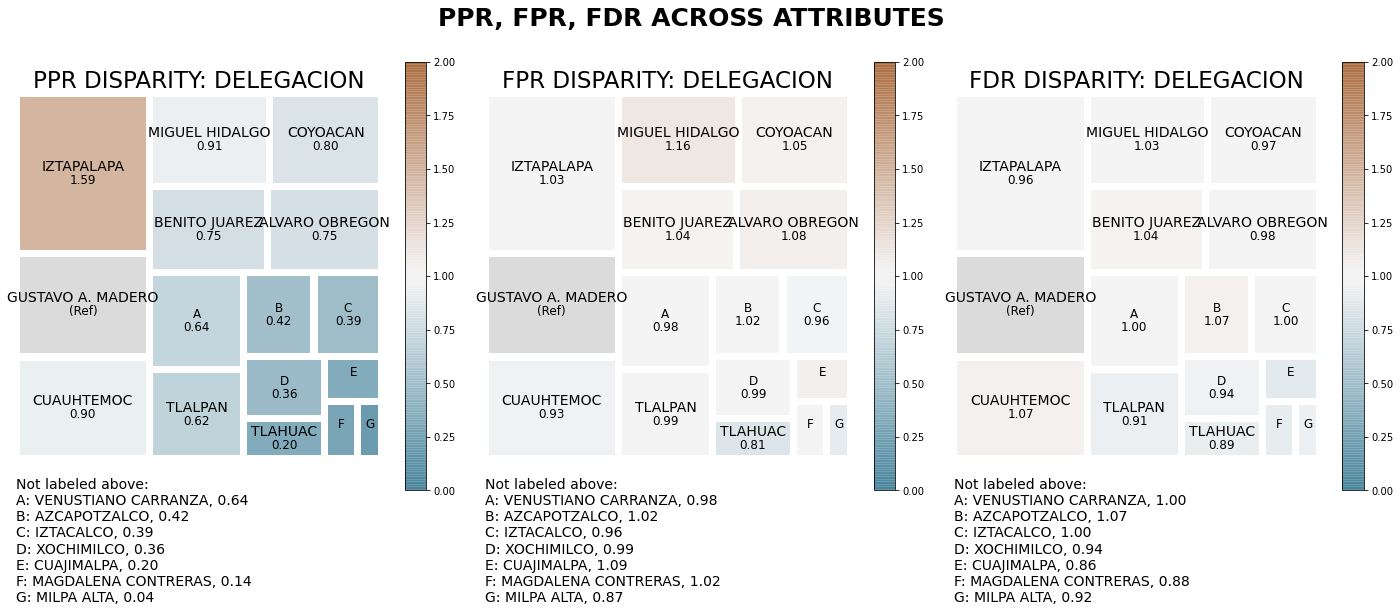

In [36]:
p = aeq.plot_disparity_all(bdf,  metrics=['ppr','fpr','fdr'], significance_alpha=0.05)

Para el sesgo:

En PPR Predicted Positive Rate podemos ver que nuestro modelo le está diciendo 1.5 veces más a la delegación Iztapalapa que las llamadas que se reciben son falsas.

### Fairness

In [37]:
fair = Fairness()

In [38]:
fdf = fair.get_group_value_fairness(bdf)

In [39]:
parity_determinations = fair.list_parities(fdf)

In [40]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,FNR Parity,Unsupervised Fairness,TNR Parity,Precision Parity,TPR Parity,FOR Parity,TypeI Parity,NPV Parity,Supervised Fairness,Impact Parity
0,delegacion,ALVARO OBREGON,0.73,0.41,0.15,0.74,0.59,0.27,0.85,0.26,...,True,False,True,True,True,False,True,True,False,True
1,delegacion,AZCAPOTZALCO,0.70,0.45,0.11,0.80,0.55,0.30,0.89,0.20,...,True,False,True,False,True,True,True,True,True,True
2,delegacion,BENITO JUAREZ,0.75,0.44,0.11,0.79,0.56,0.25,0.89,0.21,...,True,False,True,True,True,True,True,True,True,True
3,delegacion,COYOACAN,0.76,0.43,0.13,0.73,0.57,0.24,0.87,0.27,...,True,False,True,True,True,True,True,True,True,True
4,delegacion,CUAJIMALPA,0.68,0.41,0.27,0.64,0.59,0.32,0.73,0.36,...,False,False,True,False,True,False,True,True,False,True
5,delegacion,CUAUHTEMOC,0.69,0.50,0.10,0.80,0.50,0.31,0.90,0.20,...,True,True,True,False,True,True,True,True,True,True
6,delegacion,GUSTAVO A. MADERO,0.75,0.46,0.12,0.75,0.54,0.25,0.88,0.25,...,True,True,True,True,True,True,True,True,True,True
7,delegacion,IZTACALCO,0.71,0.48,0.13,0.75,0.52,0.29,0.87,0.25,...,True,False,True,True,True,True,True,True,True,True
8,delegacion,IZTAPALAPA,0.74,0.44,0.15,0.72,0.56,0.26,0.85,0.28,...,True,False,True,True,True,False,True,True,False,True
9,delegacion,MAGDALENA CONTRERAS,0.75,0.45,0.18,0.67,0.55,0.25,0.82,0.33,...,True,False,True,False,True,False,True,True,False,True


In [41]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,False,True,True,True,False,False,True,True,True,False,True,False,True,False,False


In [42]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,162385,delegacion,ALVARO OBREGON,0.731724,0.413735,0.154143,0.740321,0.586265,...,True,True,True,True,True,True,False,True,False,False
1,0,binary 0/1,162385,delegacion,AZCAPOTZALCO,0.697722,0.450950,0.114237,0.803536,0.549050,...,True,True,True,True,False,True,True,True,False,True
2,0,binary 0/1,162385,delegacion,BENITO JUAREZ,0.749165,0.437464,0.105417,0.785115,0.562536,...,True,True,True,True,True,True,True,True,False,True
3,0,binary 0/1,162385,delegacion,COYOACAN,0.763636,0.433180,0.129331,0.731660,0.566820,...,True,True,True,True,True,True,True,True,False,True
4,0,binary 0/1,162385,delegacion,CUAJIMALPA,0.680851,0.412781,0.269417,0.643910,0.587219,...,False,True,True,True,False,True,False,True,False,False
5,0,binary 0/1,162385,delegacion,CUAUHTEMOC,0.693597,0.495613,0.099441,0.802820,0.504387,...,True,True,True,True,False,True,True,True,True,True
6,0,binary 0/1,162385,delegacion,GUSTAVO A. MADERO,0.748014,0.459148,0.115735,0.751975,0.540852,...,True,True,True,True,True,True,True,True,True,True
7,0,binary 0/1,162385,delegacion,IZTACALCO,0.706394,0.481349,0.128425,0.752439,0.518651,...,True,True,True,True,True,True,True,True,False,True
8,0,binary 0/1,162385,delegacion,IZTAPALAPA,0.738759,0.443721,0.145303,0.722816,0.556279,...,True,True,True,True,True,True,False,True,False,False
9,0,binary 0/1,162385,delegacion,MAGDALENA CONTRERAS,0.745573,0.446186,0.175676,0.665272,0.553814,...,True,True,True,True,False,True,False,True,False,False


In [43]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

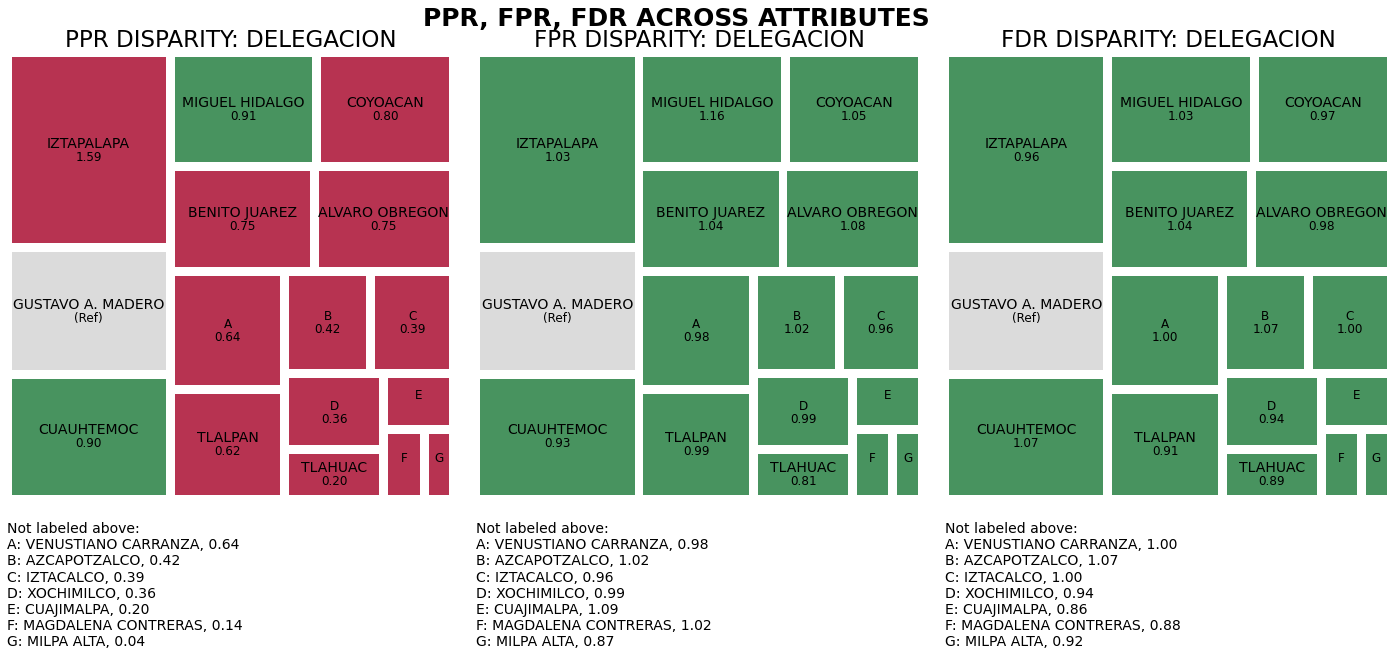

In [44]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['ppr','fpr','fdr'])

En PPR (Predicted Positive Rate): Tenemos que es injusto en la mayoría de las delegaciones si tomamos como referencia a la delegación Gustavo A. Madero, las únicas dos que no tienen son Miguel Hidalgo y Cuauhtémoc. Esto nos indica que las ambulancias que se envían en éstas delegaciones realemnte lo necesitaban.

En las otras dos métricas que seleccionamos son justas.